In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [2]:
#how to save a model
#with open("Machinelearning.sav", "rb") as f:
 # Ldmodel=joblib.load(f)

In [3]:
#Get the stock quote 
df = web.DataReader("PYPL", data_source = "yahoo", start = "2012-01-01", end = "2021-06-17") 
#Show the data 
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-07-06,39.750000,36.000000,38.000000,36.709999,5866600,36.709999
2015-07-07,37.810001,36.000000,37.720001,36.619999,7359000,36.619999
2015-07-08,36.360001,34.529999,36.340000,34.700001,5387700,34.700001
2015-07-09,35.520000,33.990002,35.099998,34.500000,3760100,34.500000
2015-07-10,35.189999,33.980000,34.660000,34.689999,4472800,34.689999
...,...,...,...,...,...,...
2021-06-11,271.899994,268.399994,268.750000,271.450012,4494600,271.450012
2021-06-14,274.970001,270.600006,271.899994,274.929993,5174200,274.929993
2021-06-15,274.730011,270.679993,274.730011,271.890015,5371100,271.890015


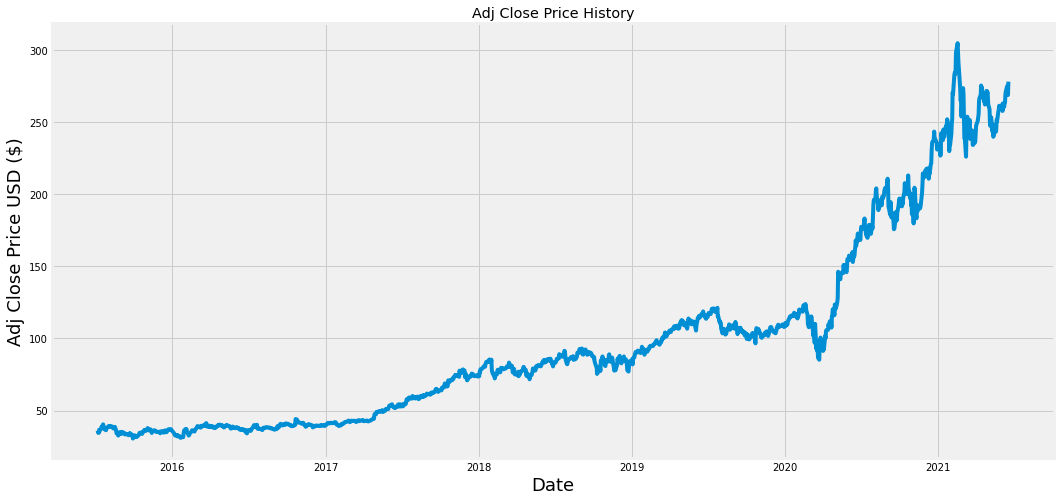

In [4]:
#Visualize the closing price history
plt.figure(figsize = (16,8))
plt.title("Adj Close Price History")
plt.plot(df["Adj Close"])
plt.xlabel("Date",fontsize=18)
plt.ylabel("Adj Close Price USD ($)", fontsize = 18)
plt.show()

In [5]:
#Create a new dataframe with only the 'Close' column
data = df.filter(["Adj Close"])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)

In [6]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [7]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [8]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [9]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [10]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units = 50, return_sequences = False))
model.add(Dense(units = 25))
model.add(Dense(units = 1))

In [11]:
#Compile the model
model.compile(optimizer ="adam", loss = "mean_squared_error")

In [12]:
#Train the model
model.fit(x_train, y_train, batch_size = 1, epochs = 6)

Epoch 1/6
1140/1140 [==============================] - 62s 33ms/step - loss: 6.2390e-04
Epoch 2/6
1140/1140 [==============================] - 38s 33ms/step - loss: 1.6907e-04
Epoch 3/6
1140/1140 [==============================] - 38s 33ms/step - loss: 1.4615e-04
Epoch 4/6
1140/1140 [==============================] - 37s 32ms/step - loss: 9.7089e-05
Epoch 5/6
1140/1140 [==============================] - 18s 16ms/step - loss: 1.0841e-04
Epoch 6/6
1140/1140 [==============================] - 15s 13ms/step - loss: 1.1346e-04


In [13]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [14]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [15]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [16]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [17]:
#Calculate/Get the value of RMSE
rmse = np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

8.01486319328345

C:\Users\jorda\Anaconda3\envs\pythondata\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


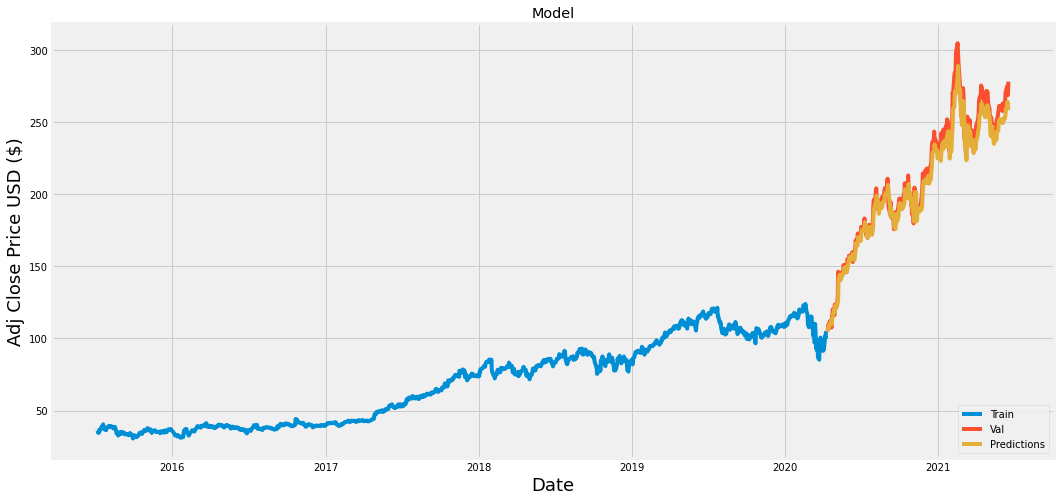

In [18]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid["Predictions"] = predictions
#Visualize the data
plt.figure(figsize = (16,8))
plt.title("Model")
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Adj Close Price USD ($)", fontsize = 18)
plt.plot(train["Adj Close"])
plt.plot(valid[["Adj Close", "Predictions"]])
plt.legend(["Train", "Val", "Predictions"], loc = "lower right")
plt.show()

In [19]:
#Show the valid and predicted prices
valid

,Adj Close,Predictions
Date,,
2020-04-09,105.839996,105.178749
2020-04-13,105.980003,106.570679
2020-04-14,109.785004,106.812004
2020-04-15,107.949997,109.194138
2020-04-16,108.309998,108.897087
...,...,...
2021-06-11,271.450012,259.163940
2021-06-14,274.929993,261.471802
2021-06-15,271.890015,264.152985


In [20]:
#Get the quote
stock_quote = web.DataReader("PYPL", data_source = "yahoo", start = "2012-01-01", end = "2021-06-17")
#Create a new dataframe
new_df = stock_quote.filter(["Adj Close"])
#Get teh last 60 day closing price 
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append teh past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[265.53128]]


In [21]:
#Get the quote
stock_quote2 = web.DataReader("PYPL", data_source = "yahoo", start = "2021-06-21", end = "2021-06-21")
print(stock_quote2["Adj Close"])

Date
2021-06-21    283.100006
Name: Adj Close, dtype: float64
